# PageRank on bipartite graph

In [7]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math
import networkx
from networkx.algorithms import bipartite

from data.data_helper_functions import *

In [2]:
%load_ext autoreload
%autoreload 2

Load a Bipartite Graph

In [115]:
data_path = '../data/'
books_df, users_df, ratings_df = load_data(data_path)
# G = load_bipartite_graph(books_df, users_df, ratings_df)

train_df, test_df = split_ratings_by_user(ratings_df, test_size = 0.2, random_state=0)

G = load_new_bipartite_graph(books_df, users_df, train_df)

Normalizing the weights

* Normalize user ratings by dividing each sigmoid value of the rating by the user's total sigmoid rating amount
* The sigmoid transformation makes a user's higher ratings have a stronger impact on recommendations while reducing the influence of lower ratings.

Testing the normalization of weights

In [15]:
average_rating = 3.5
edge_weight = 4
weight_difference = edge_weight - average_rating
sigmoid_factor = 1 / (1 + math.exp(-weight_difference))
print(sigmoid_factor)
print(edge_weight*sigmoid_factor)

0.6224593312018546
2.4898373248074184


### Personalized PageRank

* This approach computes personalized PageRank scores for the bipartite graph of users and books.
* The personalization is based on the individual user of interest. 

In [19]:
query_used_id='u-10'
personalization = {n: 0 for n in G.nodes()}
personalization[query_used_id] = 1

pagerank_scores = nx.pagerank(G, alpha=0.85, weight='sigmoid_weights', personalization=personalization) 

book_recommendations = [(node, score) for node, score in pagerank_scores.items() if node.startswith('b')]
book_recommendations.sort(key=lambda x: x[1], reverse=True)
book_recommendations = [(node, score) for (node, score) in book_recommendations if node not in G[query_used_id]]

In [20]:
# Display the top rated books by the user
user_book_ratings = ratings_df[ratings_df['user_id'] == 10]
user_book_ratings = user_book_ratings.merge(books_df, left_on='book_id', right_index=True, how='inner')
user_book_ratings = user_book_ratings[['book_id', 'title', 'authors', 'average_rating', 'rating', 'genres', 'year', 'language', 'pages']].sort_values('rating', ascending=False)
print("Top rated books by user:")
display(user_book_ratings.head())

Top rated books by user:


,book_id,title,authors,average_rating,rating,genres,year,language,pages
339570,3409,O vencedor está só,Paulo Coelho,3.37,5,"['christian', 'nonfiction', 'religion', 'spiri...",2008.0,eng,224.0
392628,3946,Matterhorn: A Novel of the Vietnam War,Karl Marlantes,4.25,5,"['young-adult', 'horror', 'fiction', 'fantasy'...",2009.0,eng,458.0
686883,7002,A Mercy,Toni Morrison,3.65,5,"['historical-fiction', 'fiction', 'romance']",2008.0,eng,368.0
150393,1506,O Zahir,"Paulo Coelho, Margaret Jull Costa",3.56,4,"['classics', 'historical-fiction', 'fiction', ...",2005.0,eng,541.0
282522,2833,El prisionero del cielo,Carlos Ruiz Zafón,3.96,4,"['fiction', 'historical-fiction', 'mystery', '...",2011.0,eng,417.0


In [21]:
book_ids = [int(book_id[2:]) for book_id, score in book_recommendations if book_id not in G[query_used_id]][:10]
selected_books = books_df.loc[book_ids]
display(selected_books.head())

,authors,year,title,average_rating,num_ratings,num_1,num_2,num_3,num_4,num_5,genres,language,pages
book_id,,,,,,,,,,,,,
3913,Milan Kundera,1990.0,Nesmrtelnost,4.12,18574,206,859,4186,8619,9244,"['mystery', 'fiction', 'crime', 'classics', 'h...",eng,212.0
2902,Paulo Coelho,1996.0,O Monte Cinco,3.61,26060,1220,3366,9197,9601,7593,"['nonfiction', 'memoir', 'classics', 'spiritua...",eng,130.0
5983,José Saramago,1991.0,O Evangelho segundo Jesus Cristo,4.26,11301,190,489,2289,5408,8232,"['fiction', 'classics']",eng,264.0
5374,"Milan Kundera, Suzanne Rappaport",1970.0,Směšné lásky,3.86,12984,179,838,4631,7271,4489,"['romance', 'contemporary', 'fiction', 'chick-...",eng,853.0
5318,"Paulo Coelho, Alan R. Clarke",1988.0,As Valkírias,3.30,14364,1099,2817,5768,4426,2844,"['fiction', 'contemporary', 'young-adult']",eng,661.0


### Topic Specific PageRank

* This approach computes personalized PageRank scores for the bipartite graph of users and books.
* The personalization is based on the normalized book ratings given by a user of interest.
* Higher normalized ratings mean that the user liked those books more.

In [26]:
query_user_id = 'u-10'
personalization_vector = {node: 0 for node in G.nodes}

# Create personalization vector - weighted vector of user's books
for book_node, edge_data in G[query_user_id].items(): 
    personalization_vector[book_node] = edge_data['normalized_sigmoid_weight']

pagerank_scores = nx.pagerank(G, alpha=0.85, weight='normalized_sigmoid_weight', personalization=personalization_vector)

book_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'book']
sorted_books = sorted(book_nodes, key=lambda book: pagerank_scores[book], reverse=True)
top_n_recommendations = [book for book in sorted_books if book not in G[query_user_id]]

In [29]:
# Display the top rated books by the user
user_book_ratings = ratings_df[ratings_df['user_id'] == 10]
user_book_ratings = user_book_ratings.merge(books_df, left_on='book_id', right_index=True, how='inner')
user_book_ratings = user_book_ratings[['book_id', 'title', 'authors', 'average_rating', 'rating', 'genres', 'year', 'language', 'pages']].sort_values('rating', ascending=False)
print("Top rated books by user:")
# display(user_book_ratings.head())

Top rated books by user:


In [30]:
book_ids = [int(book_id[2:]) for book_id in top_n_recommendations]
selected_books = books_df.loc[book_ids]
display(selected_books.head())

,authors,year,title,average_rating,num_ratings,num_1,num_2,num_3,num_4,num_5,genres,language,pages
book_id,,,,,,,,,,,,,
5812,Paulo Coelho,2000.0,Ser Como o Rio que Flui,3.93,12708,303,882,3391,4983,5064,"['poetry', 'classics', 'fiction']",eng,736.0
2902,Paulo Coelho,1996.0,O Monte Cinco,3.61,26060,1220,3366,9197,9601,7593,"['nonfiction', 'memoir', 'classics', 'spiritua...",eng,130.0
7462,Paul Auster,1992.0,Leviathan,3.95,10002,105,490,2684,5165,3350,"['young-adult', 'romance', 'contemporary', 'fi...",eng,224.0
5318,"Paulo Coelho, Alan R. Clarke",1988.0,As Valkírias,3.30,14364,1099,2817,5768,4426,2844,"['fiction', 'contemporary', 'young-adult']",eng,661.0
4606,Isabel Allende,1994.0,Paula,4.07,19852,344,1120,4491,8073,9501,"['fiction', 'fantasy', 'romance', 'chick-lit',...",eng,296.0


### Personalized PageRank Approach 3 - Item-Item Projection with User's Items in Personalization Vector

#### FIRST WAY

The first projection is based on the graph with only links where the user rated a book above or equal to their average rating. This graph represents user-book interaction, where user liked a book.

In [31]:
G_user_likes = G.copy() # Graph containing only user's positive ratings -> above his average

# Calculate the average rating for each user
for node, data in G_user_likes.nodes(data=True):
    if data['type'] == 'user':
        user_edges = G_user_likes.edges(node, data=True)
        total_weight = sum(edge_data['weight'] for _, _, edge_data in user_edges)
        G_user_likes.nodes[node]['average_rating'] = total_weight / len(user_edges)

# Remove edges with below-average ratings
for user, book, edge_data in list(G_user_likes.edges(data=True)):
    if G_user_likes.nodes[user]['type'] == 'user' and edge_data['weight'] < G_user_likes.nodes[user]['average_rating']:
        G_user_likes.remove_edge(user, book)

book_nodes = {node for node, data in G_user_likes.nodes(data=True) if data['type'] == 'book'}

# Create the book-book projection using positive ratings
liked_book_book_projection = bipartite.weighted_projected_graph(G_user_likes, book_nodes)

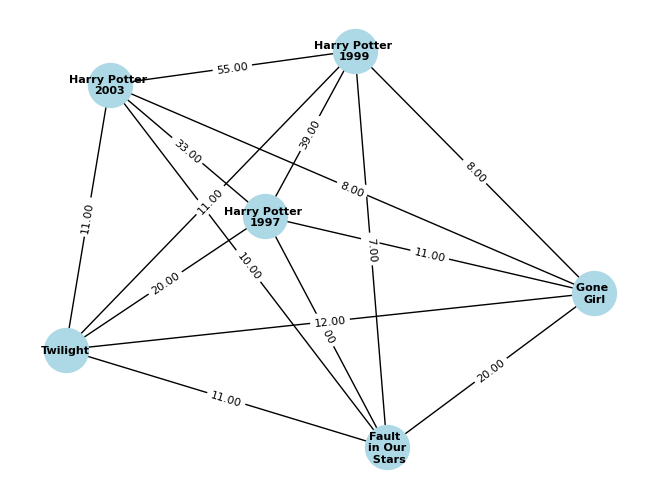

In [38]:
# Select the book nodes to visualise a sample of book-book projection
selected_books = {
    'b-2': 'Harry Potter \n1997',
    'b-18': 'Harry Potter \n1999',
    'b-21': 'Harry Potter \n2003',
    'b-3': 'Twilight',
    'b-6': 'Fault \nin Our\n Stars',
    'b-30': 'Gone \nGirl',
}

selected_book_subgraph = liked_book_book_projection.subgraph(selected_books.keys())

pos = nx.spring_layout(selected_book_subgraph, seed=10)
nx.draw(selected_book_subgraph, pos, with_labels=True, labels=selected_books, node_color='lightblue', font_weight='bold', node_size=1000, font_size=8)

edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in selected_book_subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(selected_book_subgraph, pos, edge_labels=edge_labels, font_size=8)

plt.show()

In [40]:
def create_preference_vector(G, user_id):
    edges = {book: data['normalized_sigmoid_weight'] for _, book, data in G.edges(user_id, data=True)}
    total = sum(edges.values())
    return {book: edges.get(book, 0) / total for book in book_nodes}

def predict_user(G, user_id, G_book_book_projection):
    preference_vector = create_preference_vector(G, user_id)
    already_rated_books = [book for book, preference in preference_vector.items() if preference > 0]

    item_rank = nx.pagerank(G_book_book_projection, personalization=preference_vector, alpha=0.85, weight="weight")
    sorted_books = sorted(G_book_book_projection.nodes, key=lambda x: item_rank[x], reverse=True)
    recommendations = [book for book in sorted_books if book not in already_rated_books]
    return recommendations

query_user_id = 'u-10'
recommendations = predict_user(G, query_user_id, liked_book_book_projection)
book_ids = [int(book_id[2:]) for book_id in recommendations[:10]]
selected_books = books_df.loc[book_ids]
display(selected_books.head())

,authors,year,title,average_rating,num_ratings,num_1,num_2,num_3,num_4,num_5,genres,language,pages
book_id,,,,,,,,,,,,,
39,George R.R. Martin,1996.0,A Game of Thrones,4.45,1319204,19988,28983,114092,404583,874574,"['fiction', 'fantasy', 'classics', 'contempora...",eng,460.0
87,"Elie Wiesel, Marion Wiesel",1958.0,Un di Velt Hot Geshvign,4.30,691231,7761,18539,90575,230227,360777,"['romance', 'fiction', 'contemporary', 'chick-...",eng,579.0
3913,Milan Kundera,1990.0,Nesmrtelnost,4.12,18574,206,859,4186,8619,9244,"['mystery', 'fiction', 'crime', 'classics', 'h...",eng,212.0
1835,"Paulo Coelho, Amanda Hopkinson, Nick Caistor",2000.0,O Demônio e a Srta. Prym,3.59,42286,1531,5179,15461,16402,10502,"['classics', 'fiction', 'historical-fiction']",eng,470.0
144,Laura Hillenbrand,2010.0,"Unbroken: A World War II Story of Survival, Re...",4.40,487775,10308,12874,47828,144203,313339,"['fantasy', 'young-adult', 'fiction']",eng,361.0


#### SECOND WAY
Custom book-book projection by summing the normalized sigmoid weights of the user-book ratings, resulting in an edge weight that represents the similarity between books. This projection will then be used for personalized recommendations using a preference vector and personalized PageRank algorithm.

In [41]:
def custom_weighted_projected_graph(G, projection_nodes):
    G_projection = nx.Graph()
    G_projection.add_nodes_from((node, G.nodes[node]) for node in projection_nodes)

    for index_u, u in enumerate(projection_nodes): # Iterate over all pairs of books
        for v in projection_nodes[index_u + 1:]:
            common_neighbors = set(G.neighbors(u)) & set(G.neighbors(v))
            weight = 0
            for neighbor in common_neighbors:
                u_neighbor_weight = G[u][neighbor].get('normalized_sigmoid_weight', 1)
                v_neighbor_weight = G[v][neighbor].get('normalized_sigmoid_weight', 1)
                weight += u_neighbor_weight * v_neighbor_weight
                
            if weight != 0:
                G_projection.add_edge(u, v, weight=weight*100) #Because weight are small

    return G_projection

book_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'book']
custom_book_book_projection = custom_weighted_projected_graph(G, book_nodes)

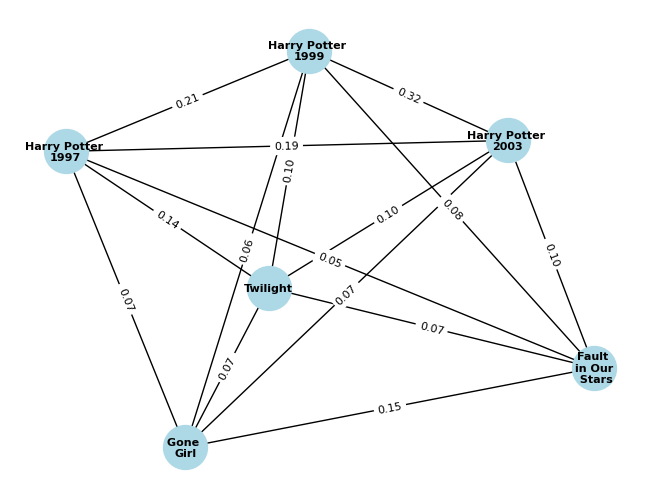

In [48]:
selected_books = {
    'b-2': 'Harry Potter \n1997',
    'b-18': 'Harry Potter \n1999',
    'b-21': 'Harry Potter \n2003',
    'b-3': 'Twilight',
    'b-6': 'Fault \nin Our\n Stars',
    'b-30': 'Gone \nGirl',
}
selected_book_subgraph = custom_book_book_projection.subgraph(selected_books.keys())

pos = nx.spring_layout(selected_book_subgraph, seed=6)
nx.draw(selected_book_subgraph, pos, with_labels=True, labels=selected_books, node_color='lightblue', font_weight='bold', node_size=1000, font_size=8)

edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in selected_book_subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(selected_book_subgraph, pos, edge_labels=edge_labels, font_size=8)

plt.show()

In [49]:
query_user_id = 'u-10'
recommendations = predict_user(G, query_user_id, custom_book_book_projection)
book_ids = [int(book_id[2:]) for book_id in recommendations[:10]]
selected_books = books_df.loc[book_ids]
display(selected_books.head())

,authors,year,title,average_rating,num_ratings,num_1,num_2,num_3,num_4,num_5,genres,language,pages
book_id,,,,,,,,,,,,,
5812,Paulo Coelho,2000.0,Ser Como o Rio que Flui,3.93,12708,303,882,3391,4983,5064,"['poetry', 'classics', 'fiction']",eng,736.0
7462,Paul Auster,1992.0,Leviathan,3.95,10002,105,490,2684,5165,3350,"['young-adult', 'romance', 'contemporary', 'fi...",eng,224.0
5983,José Saramago,1991.0,O Evangelho segundo Jesus Cristo,4.26,11301,190,489,2289,5408,8232,"['fiction', 'classics']",eng,264.0
2902,Paulo Coelho,1996.0,O Monte Cinco,3.61,26060,1220,3366,9197,9601,7593,"['nonfiction', 'memoir', 'classics', 'spiritua...",eng,130.0
4606,Isabel Allende,1994.0,Paula,4.07,19852,344,1120,4491,8073,9501,"['fiction', 'fantasy', 'romance', 'chick-lit',...",eng,296.0


### Trying to predict users ratings based on book-book projection and nearest neighbors

Idea: Use book-book projection to identify similar items (similarly to Collaborative Filtering) and predict rating 

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# It finds the k nearest neighbors of the given book that the user has already rated
def k_nearest_neighbors(G_projection, user_id, book_id, k, user_ratings):
    neighbors = sorted(G_projection[book_id].items(), key=lambda x: x[1]["weight"], reverse=True)
    rated_neighbors = [neighbor for neighbor in neighbors if (user_id, neighbor[0]) in user_ratings]
    return [neighbor[0] for neighbor in rated_neighbors[:k]]

def predict_rating(G_projection, user_id, book_id, k, user_ratings, user_biases):
    neighbors = k_nearest_neighbors(G_projection, user_id, book_id, k, user_ratings)
    numerator, denominator = 0, 0

    user_bias = user_biases[user_id]

    for neighbor in neighbors:
        similarity = G_projection[book_id][neighbor]["weight"]
        if (user_id, neighbor) in user_ratings:
            neighbor_rating = user_ratings[(user_id, neighbor)] - user_bias
            numerator += neighbor_rating * similarity
            denominator += similarity

    if denominator == 0:
        return user_bias
    return user_bias + (numerator / denominator)

Get Graph containg only ratings from train set

In [117]:
def create_train_graph(G, test_data):
    train_G = G.copy()
    for _, row in test_data.iterrows():
        user_id = 'u-' + str(row["user_id"])
        book_id = 'b-' + str(row["book_id"])
        if train_G.has_edge(user_id, book_id):
            train_G.remove_edge(user_id, book_id)
    return train_G

#### Networkx bipartite.weighted_projected_graph

In [84]:
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=0)
train_G = create_train_graph(G, test_data)

book_nodes = [node for node, data in G.nodes(data=True) if data['type'] == 'book']
train_book_book_projection = bipartite.weighted_projected_graph(train_G, book_nodes)

user_biases = {}
for user_id in users_df.index:
    user_ratings_subset = train_data[train_data['user_id'] == user_id]['rating']
    user_biases[user_id] = user_ratings_subset.mean()

In [90]:
y_true, y_pred = [], []
user_ratings = {(row["user_id"], 'b-'+str(row["book_id"])): row["rating"] for _, row in train_data.iterrows()}

for _, row in test_data.iterrows():
    predicted_rating = predict_rating(train_book_book_projection, row["user_id"], 'b-'+str(row["book_id"]), 100, user_ratings, user_biases)
    if(np.isnan(predicted_rating)): continue # Users has to few ratings -> only one in testset
    y_true.append(row["rating"])
    y_pred.append(predicted_rating)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.8515239256392877
MAE: 0.6268717867935878


## Evaluating pagerank approaches

In [120]:
def precision_recall_at_k(user_id, top_n_recommendations):
    relevant_items  = set(test_df[(test_df.user_id == user_id) & (test_df.rating>=3)]['book_id'])
    if len (relevant_items ) == 0: return -1, -1 # Can not evaluate this user if no relavant items in test set
    true_positives = len(relevant_items.intersection(set(top_n_recommendations)))

    false_positives = len(top_n_recommendations) - true_positives
    false_negatives = len(relevant_items) - true_positives

    tp, fp, fn = true_positives, false_positives, false_negatives

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    return precision, recall

Get top n recommendations for each user in a sample

In [118]:
from tqdm import tqdm
import random
random.seed(42)

user_ids = ratings_df['user_id'].unique()
sample_user_ids = random.sample(list(user_ids), 500)
sample_user_ids = ["u-" + str(user_id) for user_id in sample_user_ids]

### Personalized Pagerank

Get recommendations for each user is a sample based on ppr scores

In [119]:
k = 200

all_book_ids = set(ratings_df['book_id'].unique())
ppr_recommendations = {}
for user_id in tqdm(sample_user_ids, desc="Getting recommendations for users in a sample"):
    personalization = {n: 0 for n in G.nodes()}
    personalization[user_id] = 1
    pagerank_scores = nx.pagerank(G, alpha=0.85, weight='sigmoid_weights', personalization=personalization) 

    book_recommendations = [(node, score) for node, score in pagerank_scores.items() if node.startswith('b') and  node not in G[user_id]]
    book_recommendations.sort(key=lambda x: x[1], reverse=True)
    ppr_recommendations[user_id] = [int(node[2:]) for node, score in book_recommendations[:k]]

Getting recommendations for users in a sample: 100%|██████████| 500/500 [1:00:06<00:00,  7.21s/it]


In [121]:
total_precision = 0
total_recall = 0
count = len(user_ids)

for user_id in tqdm(sample_user_ids, desc="Evaluating recommendations"):
    top_n_recommendations = ppr_recommendations[user_id]
    precision, recall = precision_recall_at_k(int(user_id[2:]), top_n_recommendations)

    if precision > 0:
        total_precision += precision
        total_recall += recall
    elif precision < 0: # There were no relavant items
        count -=1

average_precision = total_precision / count
average_recall = total_recall / count
print(f"Precision@{k}: {average_precision:.8f}")
print(f"Recall@{k}: {average_recall:.8f}")

Evaluating recommendations: 100%|██████████| 500/500 [00:01<00:00, 331.34it/s]

Precision@200: 0.00018337
Recall@200: 0.00739943


### Topic-specific Pagerank

Get recommendations for each user is a sample based on topic specific pr scores

In [122]:
k = 200

all_book_ids = set(ratings_df['book_id'].unique())
tppr_recommendations = {}
for user_id in tqdm(sample_user_ids, desc="Getting recommendations for users in a sample"):
    # Create personalization vector
    personalization_vector = {node: 0 for node in G.nodes}
    for book_node, edge_data in G[user_id].items(): 
        personalization_vector[book_node] = edge_data['normalized_sigmoid_weight']

    pagerank_scores = nx.pagerank(G, alpha=0.85, weight='normalized_sigmoid_weight', personalization=personalization_vector)
    book_recommendations = [(node, score) for node, score in pagerank_scores.items() if node.startswith('b') and  node not in G[user_id]]
    book_recommendations.sort(key=lambda x: x[1], reverse=True)
    tppr_recommendations[user_id] = [int(node[2:]) for node, score in book_recommendations[:k]]

Getting recommendations for users in a sample: 100%|██████████| 500/500 [1:00:07<00:00,  7.22s/it]


In [136]:
total_precision = 0
total_recall = 0
count = len(user_ids)
k=200

for user_id in tqdm(sample_user_ids, desc="Evaluating recommendations"):
    top_n_recommendations = tppr_recommendations[user_id]
    precision, recall = precision_recall_at_k(int(user_id[2:]), top_n_recommendations)

    if precision > 0:
        total_precision += precision
        total_recall += recall
    elif precision < 0: # There were no relavant items
        count -=1

average_precision = total_precision / count
average_recall = total_recall / count
print(f"Precision@{k}: {average_precision:.8f}")
print(f"Recall@{k}: {average_recall:.8f}")

Evaluating recommendations: 100%|██████████| 500/500 [00:01<00:00, 377.64it/s]

Precision@200: 0.00008091
Recall@200: 0.00831558
